In [1]:
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 50)

In [2]:
df_raw = pd.read_parquet('./data/yellow_tripdata_2022-01.parquet')


df_raw['duration'] = df_raw.tpep_dropoff_datetime - df_raw.tpep_pickup_datetime
df_raw['duration'] = df_raw['duration'].dt.total_seconds()/60

df_filter = df_raw[(df_raw.duration >= 1) & (df_raw.duration <= 60)].copy()

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df_filter[categorical] = df_filter[categorical].astype(str)

In [3]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421440 entries, 0 to 2463930
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           object        
 8   DOLocationID           object        
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [4]:
df_raw['duration'].std()

46.44530513776499

In [5]:
ratio_data_left = len(df_filter) / len(df_raw)
ratio_data_left

0.9827547930522406

In [6]:
train_dicts = df_filter[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_filter[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.001496179434409

In [7]:
X_train.shape

(2421440, 516)

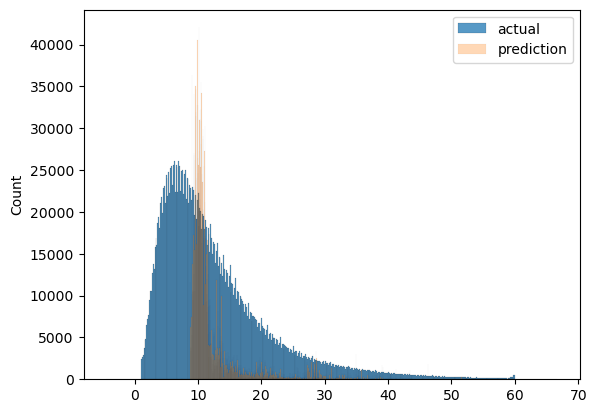

In [8]:
sns.histplot(y_train, label='actual')
sns.histplot(y_pred, label='prediction', alpha=.3)
plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2022-02.parquet')

In [11]:
len(df_train), len(df_val)

(2421440, 2918187)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [19]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [20]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.530354906009318

In [21]:
y_pred_train = lr.predict(X_train)
mean_squared_error(y_train, y_pred_train, squared=False)

4.797273774806811

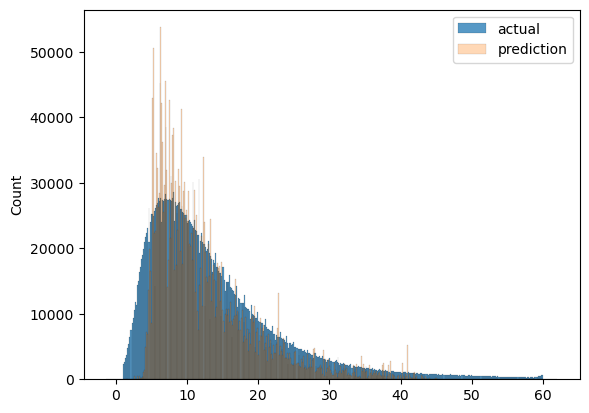

In [22]:
sns.histplot(y_val, label='actual')
sns.histplot(y_pred, label='prediction', alpha=.3)
plt.legend()

In [23]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [24]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)